In [2]:
from numpy import *
from numpy.random import *
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from PlotFuncs import *
from LabFuncs import *
from Params import *
from HaloFuncs import *
from scipy.stats import norm
import pandas
import cmocean
from copy import copy


df = pandas.read_csv('../data/Gaia-SDSS.csv')
df_S = pandas.read_csv('../data/GAIA_SDSS_Shards.csv')
names = df_S.group_id.unique()

# Extract halo
means_init = zeros(shape=(3,4))
means_init[0,:] = array([0.0,0.0,0.0,-1.4]) # Sausage
means_init[1,:] = array([0.0,0.0,0.0,-2.0]) # Halo
means_init[2,:] = array([0.0,126.0,0.0,-1.8]) # Halo
weights_init = array([0.5,0.34,0.16])
covariance_type = 'full'
vdata = array([df.GalRVel,df.GalphiVel,df.GalzVel,df.feh]).T
clf = mixture.GaussianMixture(n_components=3, covariance_type=covariance_type,
                              weights_init=weights_init,means_init=means_init,tol=1e-12,reg_covar=1e-8,max_iter=1000)
clf.fit(vdata)
Ps = clf.predict_proba(vdata)
meens = clf.means_
covs = clf.covariances_
ws = clf.weights_
eta = ws[0]
Ps = clf.predict_proba(vdata)



(18926, 57)

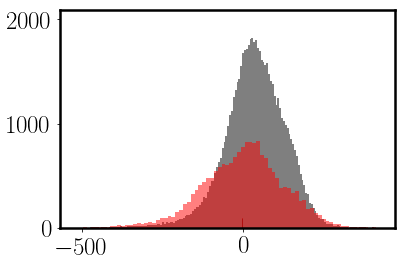

In [70]:
#imod = (Ps[:,0]<0.6826071834272386)&(Ps[:,2]<0.5347013158125022)
#imod = (Ps[:,1]>0.8)
imod = argmax(Ps,axis=1)
df2 = df.loc[imod==1]

plt.hist(df.feh,bins='fd',color='k',alpha=0.5)
plt.hist(df2.feh,bins='fd',color='r',alpha=0.5)

plt.hist(df.GalphiVel,bins='fd',color='k',alpha=0.5)
plt.hist(df2.GalphiVel,bins='fd',color='r',alpha=0.5)

shape(df2)

In [15]:
df1 = df.loc[argmax(Ps,axis=1)==0]
df3 = df.loc[argmax(Ps,axis=1)==2]

In [71]:
from sklearn.neighbors.kde import KernelDensity
from sklearn import preprocessing

JR = log10(df2.JR.values)
Jphi = df2.Jphi.values
Jz = log10(df2.Jz.values)
E = df2.E.values
feh = df2.feh.values

data = array([JR,Jphi,Jz]).T
scale = preprocessing.MinMaxScaler()
data_s = scale.fit_transform(data)

bw = 0.02
kde = KernelDensity(kernel='gaussian', bandwidth=bw).fit(data_s)
L = kde.score_samples(data_s)
L -= amax(L)
L *= 2.0

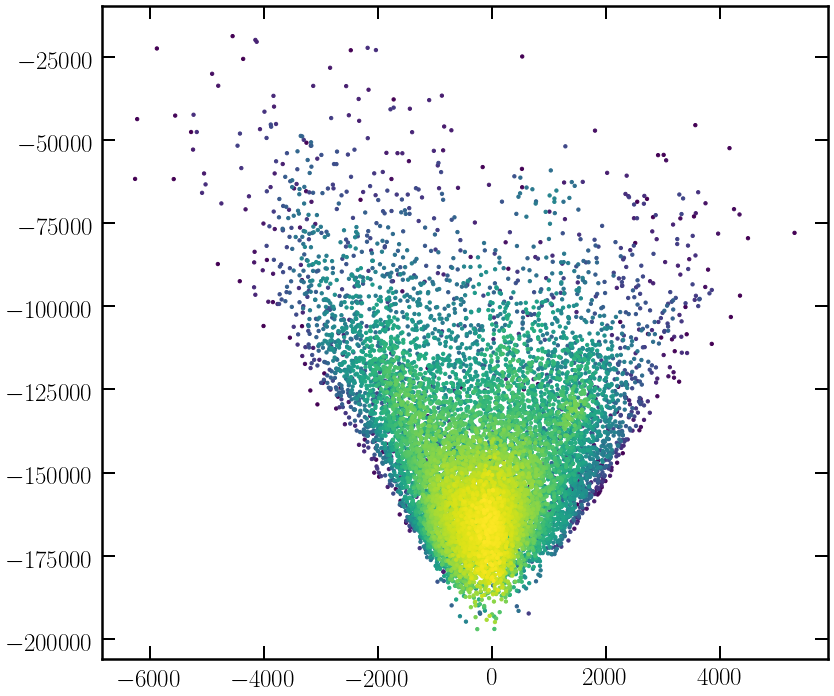

In [57]:
fig,ax1 = MySquarePlot('','')

isort = argsort(L)
ax1.scatter(Jphi[isort],E[isort],c=L[isort],s=11,rasterized=True)
plt.show()


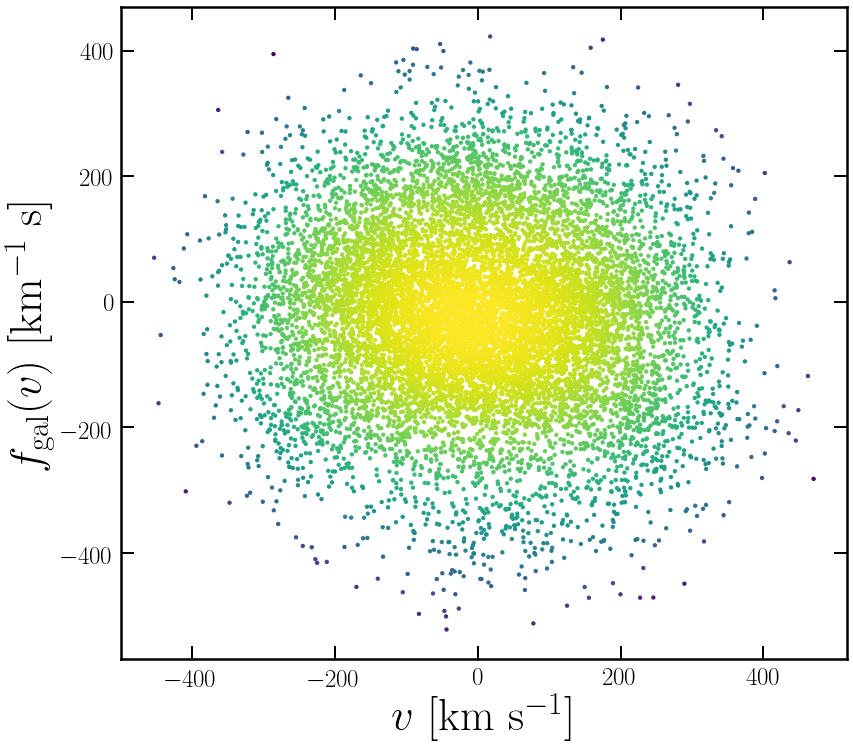

In [9]:
xlab1 = r"$v$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v)$ [km$^{-1}$ s]"
fig,ax1 = MySquarePlot(xlab1,ylab1)

data = array([df2.GalRVel.values,df2.GalphiVel.values]).T
scale = preprocessing.MinMaxScaler()
data_s = scale.fit_transform(data)

bw = 0.02
kde = KernelDensity(kernel='gaussian', bandwidth=0.1).fit(data_s)
Lv = kde.score_samples(data_s)
Lv -= amax(Lv)
Lv *= 2.0

isort = argsort(Lv)
ax1.scatter(df2.GalRVel.values[isort],df2.GalphiVel.values[isort],c=Lv[isort],s=11,rasterized=True)
plt.show()

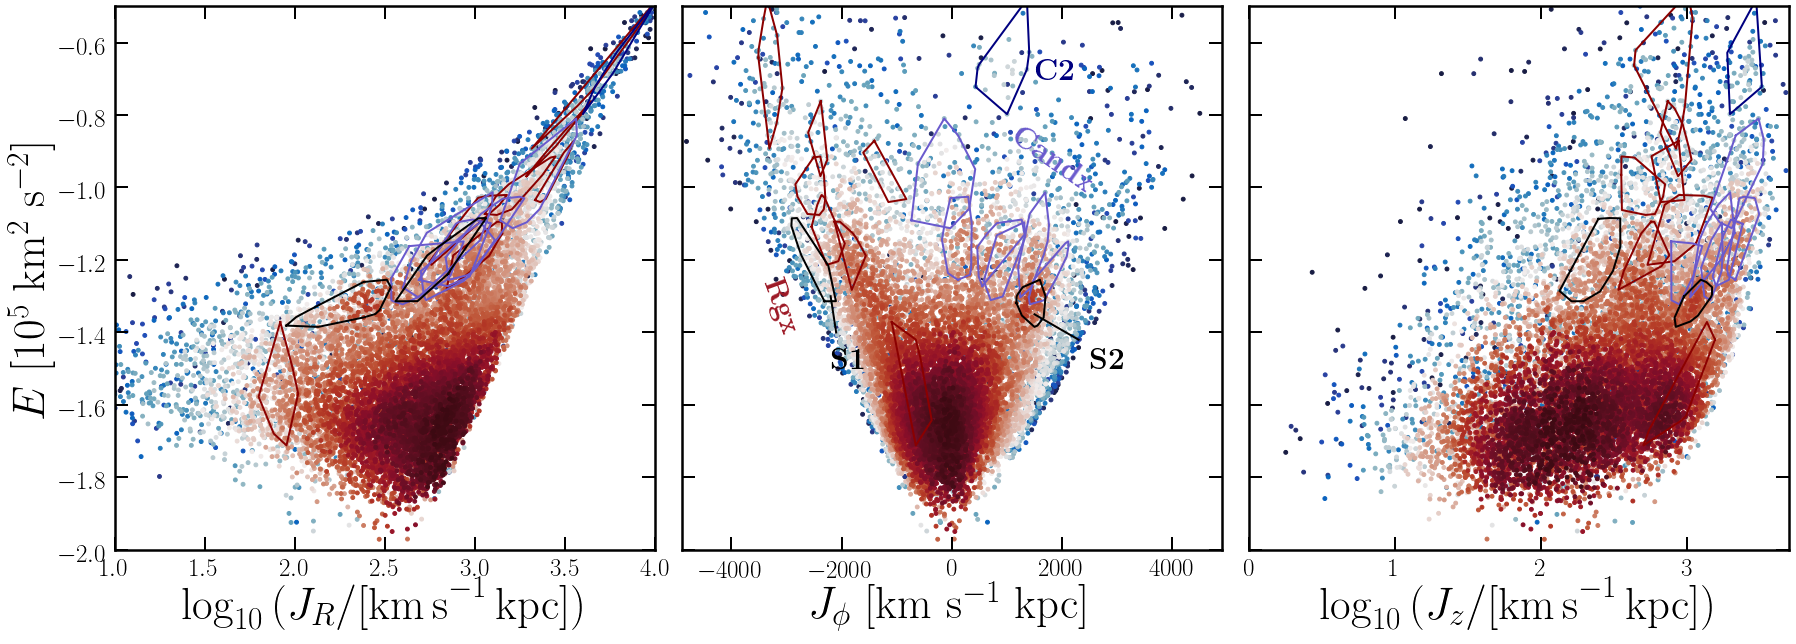

In [58]:
rlab = r'$\log_{10}{(J_R/{\rm [km\,s}^{-1}\,{\rm kpc}])}$'
plab = r'$J_\phi$ [km s$^{-1}$ kpc]'
zlab = r'$\log_{10}{(J_z/{\rm [km\,s}^{-1}\,{\rm kpc}])}$'
Elab = r'$E$ [$10^5$ km$^2$ s$^{-2}$]'

cmap = cmocean.cm.balance

Emax = -0.5
Emin = -2.0
jrmin = log10(10.0)
jrmax = log10(10000.0)
jpmin = -4900.0
jpmax = 4900.0
jzmin = log10(1.0)
jzmax = log10(5000.0)

alph = 0.2
cmap2 = cmocean.cm.solar
cmap1 = cmocean.cm.ice
cmap3 = cmocean.cm.speed


fig,ax1,ax2,ax3 = MyTriplePlot(rlab,Elab,plab,'',zlab,'',wspace=0.05,size_y=10,size_x=30)


ax1.set_ylim([Emin,Emax])
ax2.set_ylim([Emin,Emax])
ax3.set_ylim([Emin,Emax])

ax1.set_xlim([jrmin,jrmax])
ax2.set_xlim([jpmin,jpmax])
ax3.set_xlim([jzmin,jzmax])

isort = argsort(L)

ax1.scatter(JR[isort],E[isort]/1.0e5,c=L[isort], s=15,cmap=cmap,label=None,rasterized=True)
ax2.scatter(Jphi[isort],E[isort]/1.0e5,c=L[isort], s=15,cmap=cmap,label=None,rasterized=True)
ax3.scatter(Jz[isort],E[isort]/1.0e5,c=L[isort], s=15,cmap=cmap,label=None,rasterized=True)

ax2.set_yticklabels([])
ax3.set_yticklabels([])


####

def PlotShardz(Examples,cols,col_edge):
    n_ex = size(Examples)
    for i in range(0,n_ex):
        shards_color = cols[i,:]

        namei = Examples[i]
        Cand = df_S.loc[df_S['group_id'] == namei]
        Cand_matched = df.loc[around(df.ra,8).isin(Cand.ra)]
        rs = log10(Cand_matched.JR).values
        ps = (Cand_matched.Jphi).values
        zs = log10(Cand_matched.Jz).values
        es = (Cand_matched.E).values/1.0e5

        points = array([rs,es]).T
        hull = ConvexHull(points)
        x_edge = points[hull.vertices,0]
        y_edge = points[hull.vertices,1]
        ax1.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.0,color=shards_color,zorder=2)
        ax1.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color=col_edge,lw=2,zorder=2)

        points = array([ps,es]).T
        hull = ConvexHull(points)
        x_edge = points[hull.vertices,0]
        y_edge = points[hull.vertices,1]
        ax2.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.0,color=shards_color,zorder=2)
        ax2.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color=col_edge,lw=2,zorder=2)

        points = array([zs,es]).T
        hull = ConvexHull(points)
        x_edge = points[hull.vertices,0]
        y_edge = points[hull.vertices,1]
        ax3.fill(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),alpha=0.0,color=shards_color,zorder=2)
        ax3.plot(append(x_edge,x_edge[0]),append(y_edge,y_edge[0]),color=col_edge,lw=2,zorder=2)
    return _


# Plot some shards
fs = 30

Examples = array(['Rg1','Rg2','Rg3','Rg4','Rg5','Rg6','Rg7'])
cols = flipud(cmocean.cm.amp(linspace(0,0.7,size(Examples))))
PlotShardz(Examples,cols,'Darkred')
ax2.text(-3500.0,-1.3,r'{\bf Rg}\texttt{x}',fontsize=fs,color=cols[0,:],rotation=-70)
#ax2.plot([-4500.0,-1200.0],[-0.75,-1.75],'-',color=cols[0,:],lw=3.5,alpha=0.7)

Examples = array(['Cand8','Cand9','Cand10','Cand11','Cand12','Cand13'])
cols = flipud(cm.Purples(linspace(0.2,0.5,size(Examples))))
PlotShardz(Examples,cols,'slateblue')
ax2.text(1000.0,-0.88,r'{\bf Cand}\texttt{x}',fontsize=fs,color='slateblue',rotation=-35)
#ax2.plot([-300.0,2500.0],[-0.75,-1.05],'-',color=cols[0,:],lw=3.5,alpha=0.7)
#ax2.plot([-300.0,-450.0],[-0.75,-0.8],'-',color=cols[0,:],lw=3.5,alpha=0.7)


Examples = array(['S1'])
cols[0,:] = array([1.0,1.0,1.0,1.0])
PlotShardz(Examples,cols,'k')
ax2.text(-2200.0,-1.5,r'{\bf S1}',fontsize=fs,color='k')
ax2.plot([-2100,-2200],[-1.4,-1.3],'k-',lw=2)     


Examples = array(['S2'])
cols[0,:] = array([1.0,1.0,1.0,1.0])
PlotShardz(Examples,cols,'k')
ax2.text(2500.0,-1.5,r'{\bf S2}',fontsize=fs,color='k')
ax2.plot([2300,1500],[-1.42,-1.35],'k-',lw=2)     


Examples = array(['C2'])
cols[0,:] = array([0.0,0.0,0.5,1.0])
PlotShardz(Examples,cols,'navy')
ax2.text(1500.0,-0.7,r'{\bf C2}',fontsize=fs,color=cols[0,:])


####




plt.show()

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:32: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.



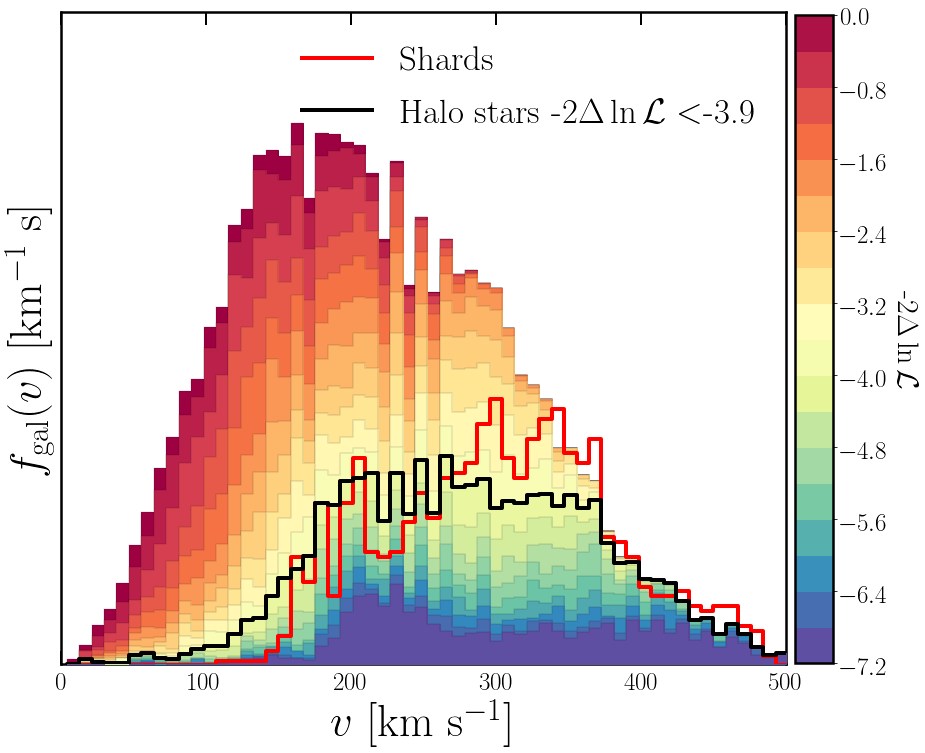

In [59]:
xlab1 = r"$v$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v)$ [km$^{-1}$ s]"
fig,ax1 = MySquarePlot(xlab1,ylab1)
ax1.set_xlim([0,500])
ax1.set_ylim(bottom=0.01,top=5.)

def speeds(dfc,v_lab=array([0.0,0.0,0.0])):
    return sqrt(dfc.GalRVel**2.0+(dfc.GalphiVel-v_lab[1])**2.0+(dfc.GalzVel-v_lab[2])**2.0)
    

nbins = 70
nLbins = 20
Lbins = flipud(linspace(-7,0.0,nLbins+1))

n0 = shape(df2)[0]
zorder = 0
cmap = cm.Spectral
col_ex = (cmap(linspace(0,1,nLbins)))

# Shards
vv = sqrt(df_S.GalRVel**2.0+df_S.GalTVel**2.0+df_S.GalzVel**2.0)
h_shards,vbins = histogram(vv,bins=nbins,normed=True,range=(0,600))
f1 = h_shards/sum(h_shards)

chi2a = zeros(shape=nLbins)
Norma = zeros(shape=nLbins)
f0 = zeros(shape=(nLbins,nbins))
zorder = 0
for i in range(0,nLbins):
    col = col_ex[i,:] 
    dfc = df2.loc[L<Lbins[i]]
    h_E0,vbins = histogram(speeds(dfc),bins=nbins,normed=True,range=(0,600))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= sum(L<Lbins[i])/(1.0*n0)
    ax1.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=1.0,step='pre',zorder=zorder)
    ax1.step(vc,1e3*h_E0,'k-',lw=1.5,zorder=zorder,alpha=0.1)
    zorder += 1
    
    f0[i,:] = h_E0/sum(h_E0)
    chi2a[i] = sum((f1-f0[i,:])**2.0)
    Norma[i] = sum(h_E0)

imin = argmin(chi2a)
ax1.step(vc,1e3*f1*Norma[imin],'-',color='r',lw=4,zorder=zorder,label='Shards')
ax1.step(vc,1e3*f0[imin,:]*Norma[imin],'-',\
         color='k',lw=4,zorder=zorder,label=r'Halo stars -$2\Delta\ln \mathcal{L}<$'+'{:.1f}'.format(Lbins[imin]))
ax1.legend(frameon=False,fontsize=35)


ax1.set_yticks([])

#plt.yscale('log')


lf = array([[amax(Lbins),0],[amin(Lbins),0]])
cbar_ax = fig.add_axes([0.91, 0.126, 0.04, 0.75])
im = ax1.contourf([-2*600,-1.5*600],[0.1,0.1],lf,size(Lbins),cmap=cm.Spectral_r,vmin=amin(Lbins),vmax=amax(Lbins))
fig.colorbar(im, cax=cbar_ax,boundaries=Lbins)
cbar_ax.set_ylabel(r'-$2\Delta \ln \mathcal{L}$',rotation=-90,labelpad=30.0,fontsize=30)

# Save
plt.show()
#pltname = 'fv1_halo_highL'
#fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
#fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')    

In [33]:
Norma[imin]

nan

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Passing `normed=True` on non-

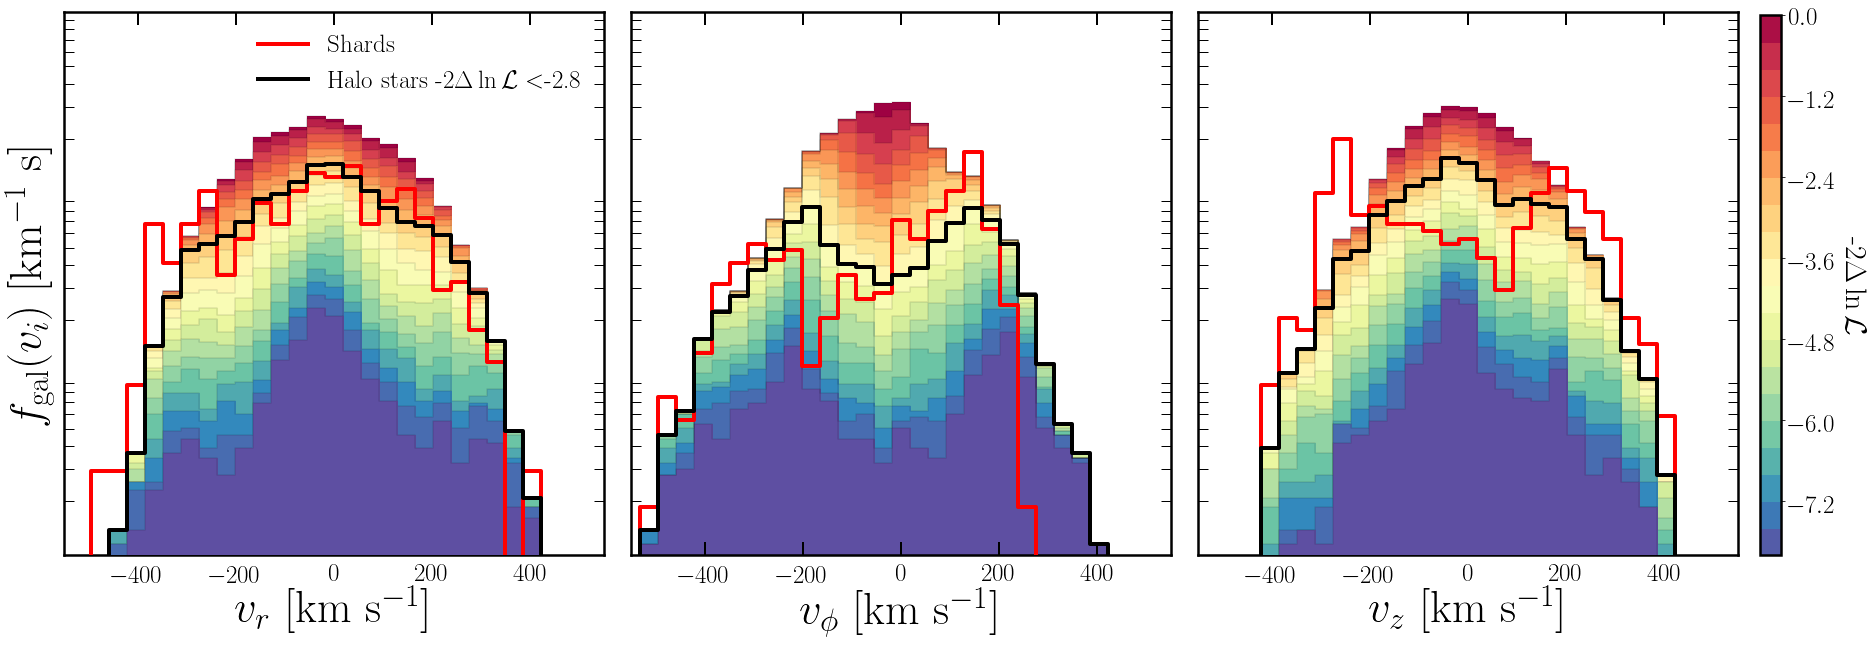

In [69]:
vlab1 = r"$v_r$ [km s$^{-1}$]"
vlab2 = r"$v_\phi$ [km s$^{-1}$]"
vlab3 = r"$v_z$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v_i)$ [km$^{-1}$ s]"
fig,ax1,ax2,ax3 = MyTriplePlot(vlab1,ylab1,vlab2,'',vlab3,'',wspace=0.05,size_y=10,size_x=30,tfs=25)
ymax = 10.0
ymin = 0.01
vmax = 550.0
ax1.set_xlim([-vmax,vmax])
ax1.set_ylim(bottom=ymin,top=ymax)
ax2.set_xlim([-vmax,vmax])
ax2.set_ylim(bottom=ymin,top=ymax)
ax3.set_xlim([-vmax,vmax])
ax3.set_ylim(bottom=ymin,top=ymax)


nbins = 30
nLbins = 20
Lbins = flipud(linspace(-8.0,0.0,nLbins+1))

n0 = shape(df2)[0]
zorder = 0
col_ex = (cm.Spectral(linspace(0,1,nLbins)))

# R
h_shards,vbins = histogram(df_S.GalRVel[0:500],bins=nbins,normed=True,range=(-vmax,vmax))
f1 = h_shards/sum(h_shards)
chi2a = zeros(shape=nLbins)
Norma = zeros(shape=nLbins)
f0 = zeros(shape=(nLbins,nbins))
zorder=0
for i in range(0,nLbins):
    col = col_ex[i,:] 
    dfc = df2.loc[L<Lbins[i]]
    h_E0,vbins = histogram(dfc.GalRVel.values,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= sum(L<Lbins[i])/(1.0*n0)
    ax1.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=1.0,step='pre',zorder=zorder)
    ax1.step(vc,1e3*h_E0,'k-',lw=1.5,zorder=zorder,alpha=0.1)
    zorder += 1
    
    f0[i,:] = h_E0/sum(h_E0)
    chi2a[i] = sum((f1-f0[i,:])**2.0)
    Norma[i] = sum(h_E0)

imin1 = argmin(chi2a)
ax1.step(vc,1e3*f1*Norma[imin1],'-',color='r',lw=4,zorder=zorder,label='Shards')
ax1.step(vc,1e3*f0[imin1,:]*Norma[imin1],'-',\
         color='k',lw=4,zorder=zorder,label=r'Halo stars -$2\Delta\ln \mathcal{L}<$'+'{:.1f}'.format(Lbins[imin1]))
ax1.legend(frameon=False,fontsize=25)


# phi
h_shards,vbins = histogram(df_S.GalTVel[0:500],bins=nbins,normed=True,range=(-vmax,vmax))
f1 = h_shards/sum(h_shards)
chi2a = zeros(shape=nLbins)
Norma = zeros(shape=nLbins)
zorder=0
f0 = zeros(shape=(nLbins,nbins))
for i in range(0,nLbins):
    col = col_ex[i,:] 
    dfc = df2.loc[L<Lbins[i]]
    h_E0,vbins = histogram(dfc.GalphiVel.values,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= sum(L<Lbins[i])/(1.0*n0)
    ax2.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=1.0,step='pre',zorder=0)
    ax2.step(vc,1e3*h_E0,'k-',lw=1.5,zorder=zorder,alpha=0.1)
    zorder += 1
    
    f0[i,:] = h_E0/sum(h_E0)
    chi2a[i] = sum((f1-f0[i,:])**2.0)
    Norma[i] = sum(h_E0)

imin2 = argmin(chi2a)
ax2.step(vc,1e3*f1*Norma[imin2],'-',color='r',lw=4,zorder=zorder)
ax2.step(vc,1e3*f0[imin2,:]*Norma[imin2],'-',color='k',lw=4,zorder=zorder)



# z
h_shards,vbins = histogram(df_S.GalzVel[0:500],bins=nbins,normed=True,range=(-vmax,vmax))
f1 = h_shards/sum(h_shards)
chi2a = zeros(shape=nLbins)
Norma = zeros(shape=nLbins)
f0 = zeros(shape=(nLbins,nbins))
zorder=0
for i in range(0,nLbins):
    col = col_ex[i,:] 
    dfc = df2.loc[L<Lbins[i]]
    h_E0,vbins = histogram(dfc.GalzVel.values,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= sum(L<Lbins[i])/(1.0*n0)
    ax3.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=1.0,step='pre',zorder=zorder)
    ax3.step(vc,1e3*h_E0,'k-',lw=1.5,zorder=zorder,alpha=0.1)
    zorder += 1
    
    f0[i,:] = h_E0/sum(h_E0)
    chi2a[i] = sum((f1-f0[i,:])**2.0)
    Norma[i] = sum(h_E0)

imin3 = argmin(chi2a)
ax3.step(vc,1e3*f1*Norma[imin3],'-',color='r',lw=4,zorder=zorder)
ax3.step(vc,1e3*f0[imin3,:]*Norma[imin3],'-',color='k',lw=4,zorder=zorder)

ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')


# # Now adding the colorbar
lf = array([[amax(Lbins),0],[amin(Lbins),0]])
cbar_ax = fig.add_axes([0.91, 0.125, 0.01, 0.75])
im = ax3.contourf([-2*vmax,-1.5*vmax],[0.1,0.1],lf,size(Lbins),cmap=cm.Spectral_r,vmin=amin(Lbins),vmax=amax(Lbins))
fig.colorbar(im, cax=cbar_ax,boundaries=Lbins)
cbar_ax.set_ylabel(r'-$2\Delta \ln \mathcal{L}$',rotation=-90,labelpad=30.0,fontsize=30)

ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

# Save
plt.show()
#pltname = 'fv3_halo_highL'
#fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
#fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight') 

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

77


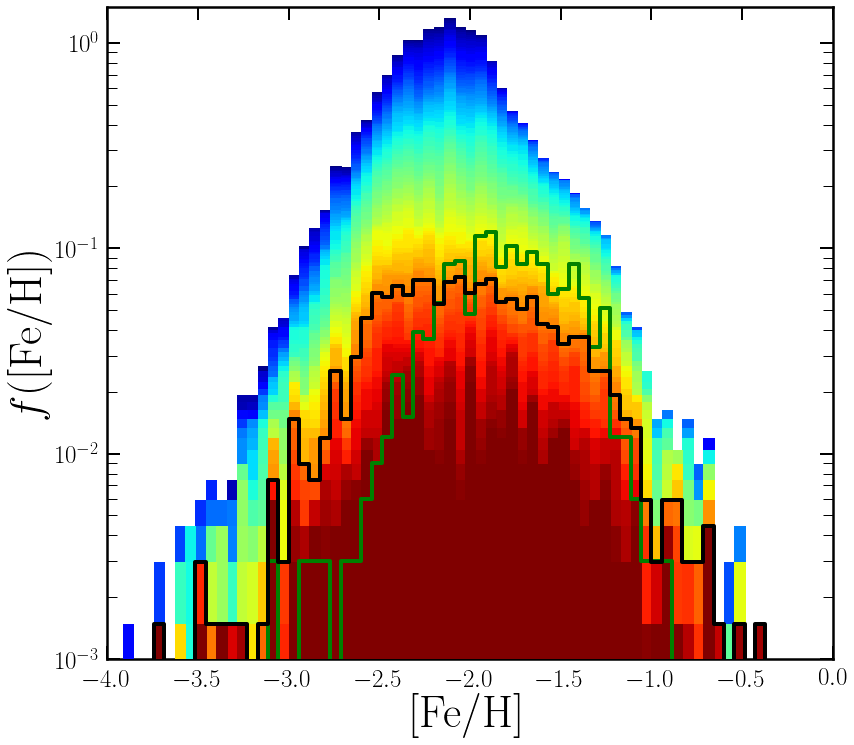

In [65]:
xlab1 = r"[Fe/H]"
ylab1 = r"$f$([Fe/H])"
fig,ax1 = MySquarePlot(xlab1,ylab1)
fehmin = -4.0
fehmax = 0.0
ax1.set_xlim([fehmin,fehmax])
ax1.set_ylim(bottom=0.001,top=1.5)
 
nbins = 70
nLbins = 100
Lbins = flipud(linspace(-9,0.0,nLbins+1))

n0 = shape(df2)[0]
zorder = 0
col_ex = (cm.jet(linspace(0,1,nLbins)))

# Shards
h_shards,vbins = histogram(df_S.feh[0:500],bins=nbins,normed=True,range=(fehmin,fehmax))
f1 = h_shards/sum(h_shards)

chi2a = zeros(shape=nLbins)
Norma = zeros(shape=nLbins)
f0 = zeros(shape=(nLbins,nbins))
zorder = 0.0
for i in range(0,nLbins):
    col = col_ex[i,:] 
    dfc = df2.loc[L<Lbins[i]]
    h_E0,vbins = histogram(dfc.feh,bins=nbins,normed=True,range=(fehmin,fehmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= sum(L<Lbins[i])/(1.0*n0)
    ax1.fill_between(vc,h_E0,y2=0,color=col,lw=None,alpha=1.0,step='pre',zorder=zorder)
    zorder += 1
    
    f0[i,:] = h_E0/sum(h_E0)
    chi2a[i] = sum((f1-f0[i,:])**2.0)
    Norma[i] = sum(h_E0)

imin = argmin(chi2a)
ax1.step(vc,f1*Norma[imin],'-',color='g',lw=4,zorder=zorder)
ax1.step(vc,f0[imin,:]*Norma[imin],'-',color='k',lw=4,zorder=zorder)

plt.yscale('log')
print(imin)

# Save
plt.show()
#pltname = 'ffeh_halo_highL'
#fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
#fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')    

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:13: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  del sys.path[0]

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.



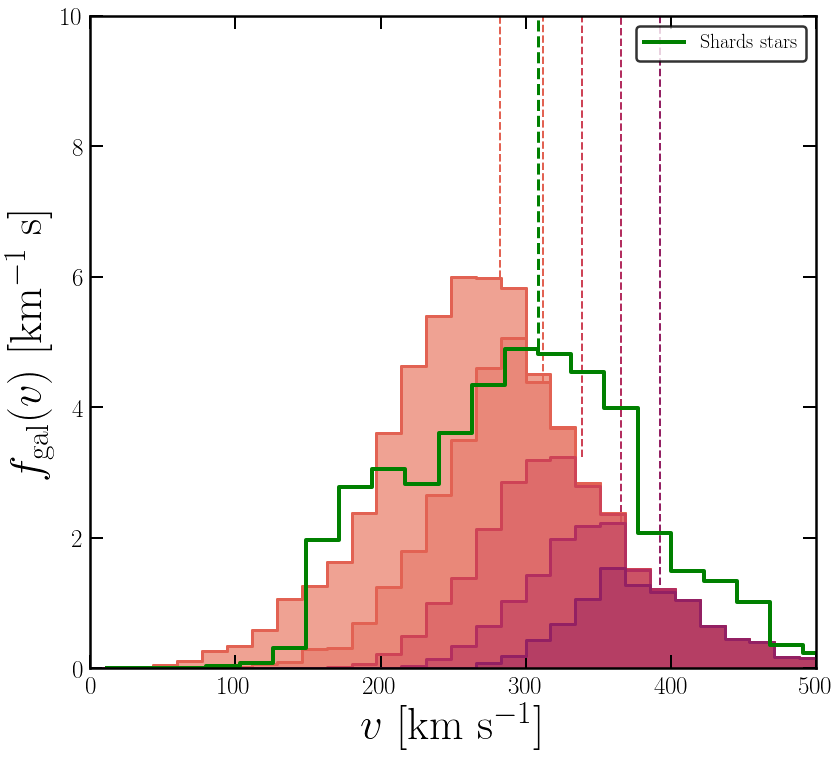

In [36]:
xlab1 = r"$v$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v)$ [km$^{-1}$ s]"
fig,ax1 = MySquarePlot(xlab1,ylab1)
ax1.set_xlim([0,500])
ax1.set_ylim(bottom=0.0,top=10.)

# High energy distribution
def plotdistE(dfc,Ecut,col,alph=0.4,nbins=35,Norm=1.0):
    df_E0 = dfc.loc[(dfc['E'] > Ecut)]
    h_E0,vbins = histogram(speeds(df_E0),bins=nbins,normed=True,range=(0,600))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= Norm
    ax1.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax1.step(vc,1e3*h_E0,'-',color=col,lw=3)

    mean0 = mean(speeds(df_E0))
    hmean0 = 1e3*h_E0[argmin(abs(vc-mean0))]
    ax1.plot([mean0,mean0],[hmean0,10.0],'--',color=col,lw=2,zorder=-10)
    return dfc

col_ex = (cmocean.cm.matter(linspace(0,1,11)))
df_E0 = plotdistE(df2,-1.5e5,col_ex[3,:],Norm=1)
n0 = sum(df2.E>-1.5e5)
df_E1 = plotdistE(df2,-1.5e5,col_ex[4,:],Norm=sum(df2.E>-1.5e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.4e5,col_ex[4,:],Norm=sum(df2.E>-1.4e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.3e5,col_ex[5,:],Norm=sum(df2.E>-1.3e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.2e5,col_ex[6,:],Norm=sum(df2.E>-1.2e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.1e5,col_ex[7,:],Norm=sum(df2.E>-1.1e5)/(1.0*n0))


# Shards
vv = sqrt(df_S.GalRVel**2.0+df_S.GalTVel**2.0+df_S.GalzVel**2.0)
h_shards,vbins = histogram(vv,bins=35,normed=True,range=(0,800))
vc = (vbins[1:]+vbins[0:-1])/2
ax1.step(vc,1e3*h_shards,'-',color='g',lw=4,label='Shards stars')
mean_shards = mean(vv)
hmean_shards = 1e3*h_shards[argmin(abs(vc-mean_shards))]
ax1.plot([mean_shards,mean_shards],[hmean_shards,10.0],'--',color='g',lw=3)


# Legend lines
leg = ax1.legend(loc='upper right',fontsize=20,edgecolor='k')
leg.get_frame().set_linewidth(2.5)


# Save
plt.show()
pltname = 'fv1_halo_shards'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')     

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:28: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:40: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:52: VisibleDeprecationWarning: Passing `normed=True` on non-

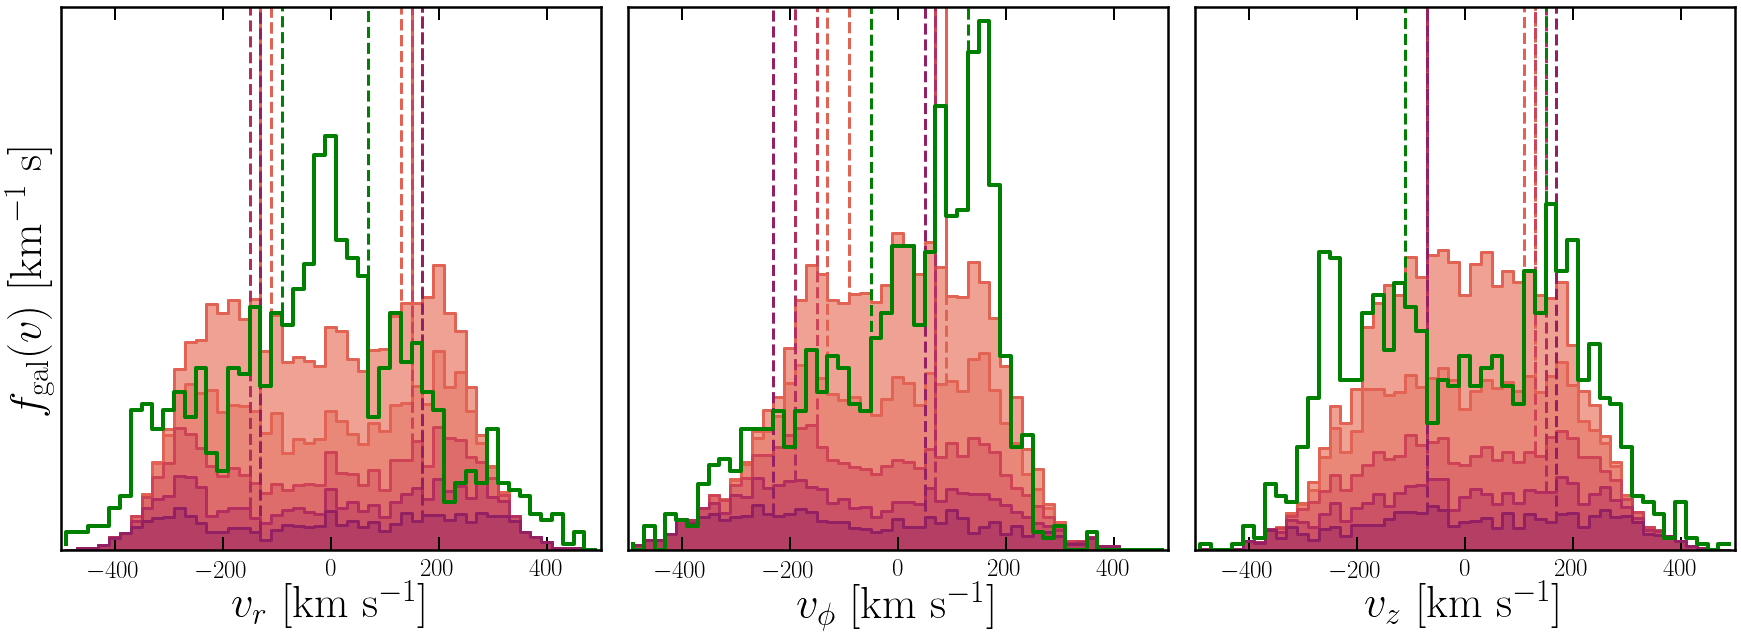

In [62]:
vlab1 = r"$v_r$ [km s$^{-1}$]"
vlab2 = r"$v_\phi$ [km s$^{-1}$]"
vlab3 = r"$v_z$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v_i)$ [km$^{-1}$ s]"
fig,ax1,ax2,ax3 = MyTriplePlot(vlab1,ylab1,vlab2,'',vlab3,'',wspace=0.05,size_y=10,size_x=30)
ymax = 4.0
vmax = 500.0
ax1.set_xlim([-vmax,vmax])
ax1.set_ylim(bottom=0.0,top=ymax)
ax2.set_xlim([-vmax,vmax])
ax2.set_ylim(bottom=0.0,top=ymax)
ax3.set_xlim([-vmax,vmax])
ax3.set_ylim(bottom=0.0,top=ymax)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

def speeds(dfc,v_lab=array([0.0,0.0,0.0])):
    vr = (dfc.GalRVel-v_lab[0])
    vphi = (dfc.GalphiVel-v_lab[1])
    vz = (dfc.GalzVel-v_lab[2])
    return vr,vphi,vz

# High energy distribution
def plotdistE(dfc,Ecut,col,alph=0.4,nbins=50,Norm=1.0):
    df_E0 = dfc.loc[(dfc['E'] > Ecut)]
    vr,vphi,vz = speeds(df_E0)
    h_E0,vbins = histogram(vr,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= Norm
    ax1.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax1.step(vc,1e3*h_E0,'-',color=col,lw=3)
    m1 = sort(vr)[round(0.32*size(vr))]
    m2 = sort(vr)[round(0.68*size(vr))]
    hm1 = 1e3*h_E0[argmin(abs(vc-m1))]
    hm2 = 1e3*h_E0[argmin(abs(vc-m2))]
    ax1.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax1.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

    h_E0,vbins = histogram(vphi,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= Norm
    ax2.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax2.step(vc,1e3*h_E0,'-',color=col,lw=3)
    m1 = sort(vphi)[round(0.32*size(vphi))]
    m2 = sort(vphi)[round(0.68*size(vphi))]
    hm1 = 1e3*h_E0[argmin(abs(vc-m1))]
    hm2 = 1e3*h_E0[argmin(abs(vc-m2))]
    ax2.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax2.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

    h_E0,vbins = histogram(vz,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h_E0 *= Norm
    ax3.fill_between(vc,1e3*h_E0,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax3.step(vc,1e3*h_E0,'-',color=col,lw=3)
    m1 = sort(vz)[round(0.32*size(vz))]
    m2 = sort(vz)[round(0.68*size(vz))]
    hm1 = 1e3*h_E0[argmin(abs(vc-m1))]
    hm2 = 1e3*h_E0[argmin(abs(vc-m2))]
    ax3.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax3.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

    return dfc

col_ex = (cmocean.cm.matter(linspace(0,1,11)))
df_E0 = plotdistE(df2,-1.5e5,col_ex[3,:],Norm=1)
n0 = sum(df2.E>-1.5e5)
df_E1 = plotdistE(df2,-1.5e5,col_ex[4,:],Norm=sum(df2.E>-1.5e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.4e5,col_ex[4,:],Norm=sum(df2.E>-1.4e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.3e5,col_ex[5,:],Norm=sum(df2.E>-1.3e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.2e5,col_ex[6,:],Norm=sum(df2.E>-1.2e5)/(1.0*n0))
df_E1 = plotdistE(df2,-1.1e5,col_ex[7,:],Norm=sum(df2.E>-1.1e5)/(1.0*n0))
# df_E0 = plotdistE(df2,-1.1e5,col_ex[3,:],Norm=1)
# df_E1 = plotdistE(df2,-1.2e5,col_ex[4,:],Norm=1)
# df_E1 = plotdistE(df2,-1.3e5,col_ex[4,:],Norm=1)
# df_E1 = plotdistE(df2,-1.4e5,col_ex[5,:],Norm=1)
# df_E1 = plotdistE(df2,-1.5e5,col_ex[6,:],Norm=1)
# df_E1 = plotdistE(df2,-1.6e5,col_ex[7,:],Norm=1)

# Shards
nbins = 50
vr = df_S.GalRVel
vphi = df_S.GalTVel
vz = df_S.GalzVel
h_shards,vbins = histogram(vr,bins=nbins,normed=True,range=(-vmax,vmax))
vc = (vbins[1:]+vbins[0:-1])/2
ax1.step(vc,1e3*h_shards,'-',color='g',lw=4)
m1 = sort(vr)[round(0.32*size(vr))]
m2 = sort(vr)[round(0.68*size(vr))]
hm1 = 1e3*h_shards[argmin(abs(vc-m1))]
hm2 = 1e3*h_shards[argmin(abs(vc-m2))]
ax1.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color='g',lw=3)
ax1.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color='g',lw=3)

h_shards,vbins = histogram(vphi,bins=nbins,normed=True,range=(-vmax,vmax))
vc = (vbins[1:]+vbins[0:-1])/2
ax2.step(vc,1e3*h_shards,'-',color='g',lw=4)
m1 = sort(vphi)[round(0.32*size(vphi))]
m2 = sort(vphi)[round(0.68*size(vphi))]
hm1 = 1e3*h_shards[argmin(abs(vc-m1))]
hm2 = 1e3*h_shards[argmin(abs(vc-m2))]
ax2.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color='g',lw=3)
ax2.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color='g',lw=3)

h_shards,vbins = histogram(vz,bins=nbins,normed=True,range=(-vmax,vmax))
vc = (vbins[1:]+vbins[0:-1])/2
ax3.step(vc,1e3*h_shards,'-',color='g',lw=4)
m1 = sort(vz)[round(0.32*size(vz))]
m2 = sort(vz)[round(0.68*size(vz))]
hm1 = 1e3*h_shards[argmin(abs(vc-m1))]
hm2 = 1e3*h_shards[argmin(abs(vc-m2))]
ax3.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color='g',lw=3)
ax3.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color='g',lw=3)



# Save
plt.show()
pltname = 'fv3_halo_shards'
fig.savefig('../plots/'+pltname+'.pdf',bbox_inches='tight')
fig.savefig('../plots/plots_png/'+pltname+'.png',bbox_inches='tight')     

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:24: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.

/Users/ciaranohare/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:48: VisibleDeprecationWarning: Passing `normed=True` on non-

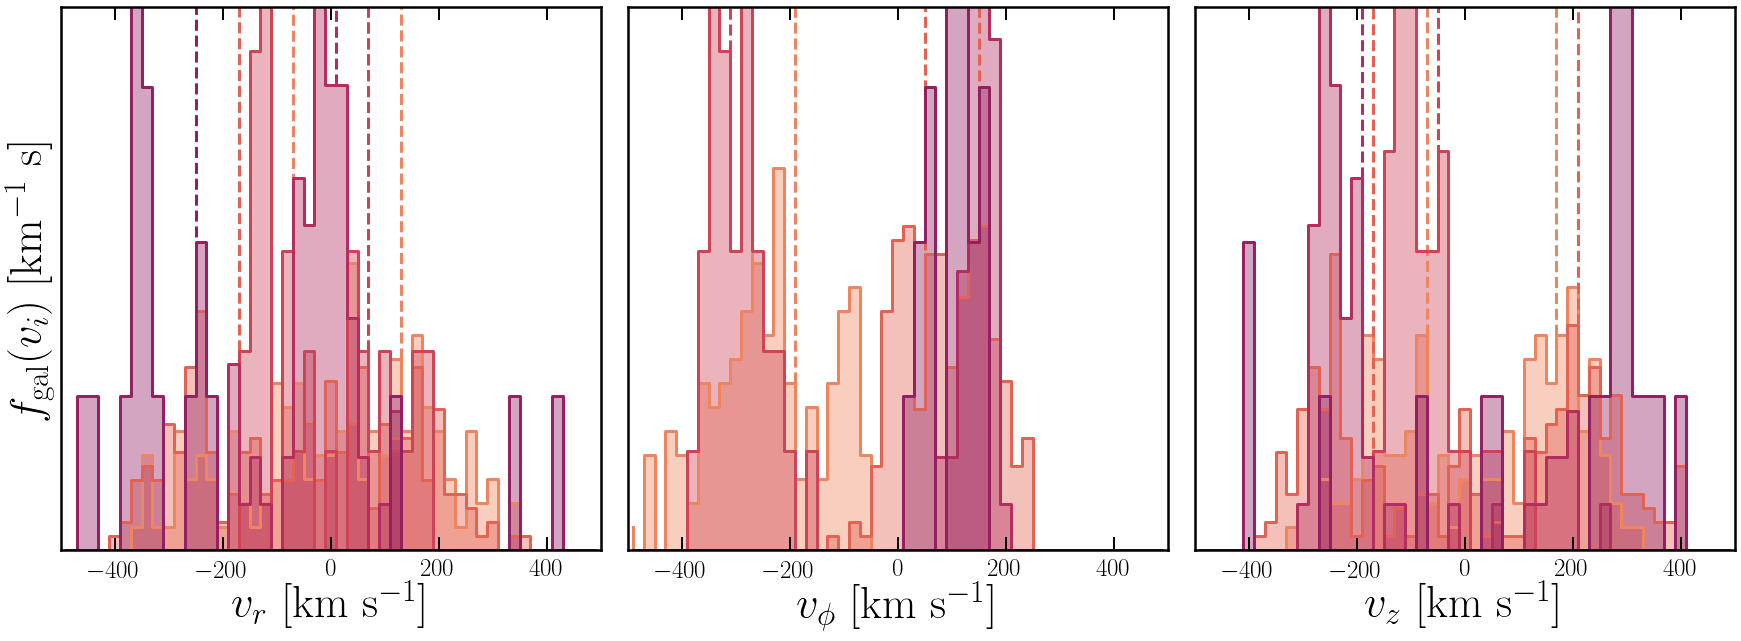

In [75]:
vlab1 = r"$v_r$ [km s$^{-1}$]"
vlab2 = r"$v_\phi$ [km s$^{-1}$]"
vlab3 = r"$v_z$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v_i)$ [km$^{-1}$ s]"
fig,ax1,ax2,ax3 = MyTriplePlot(vlab1,ylab1,vlab2,'',vlab3,'',wspace=0.05,size_y=10,size_x=30)
ymax = 8.0
vmax = 500.0
ax1.set_xlim([-vmax,vmax])
ax1.set_ylim(bottom=0.0,top=ymax)
ax2.set_xlim([-vmax,vmax])
ax2.set_ylim(bottom=0.0,top=ymax)
ax3.set_xlim([-vmax,vmax])
ax3.set_ylim(bottom=0.0,top=ymax)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])


def plotshards3(Examples,col,alph=0.4,nbins=50,Norm=1.0):
    dfc = df_S[df_S.group_id.isin(Examples)]    
    vr = dfc.GalRVel
    vphi = dfc.GalTVel
    vz = dfc.GalzVel
    h,vbins = histogram(vr,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h *= Norm
    ax1.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax1.step(vc,1e3*h,'-',color=col,lw=3)
    m1 = sort(vr)[round(0.32*size(vr))]
    m2 = sort(vr)[round(0.68*size(vr))]
    hm1 = 1e3*h[argmin(abs(vc-m1))]
    hm2 = 1e3*h[argmin(abs(vc-m2))]
    ax1.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax1.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

    h,vbins = histogram(vphi,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h *= Norm
    ax2.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax2.step(vc,1e3*h,'-',color=col,lw=3)
    m1 = sort(vphi)[round(0.32*size(vphi))]
    m2 = sort(vphi)[round(0.68*size(vphi))]
    hm1 = 1e3*h[argmin(abs(vc-m1))]
    hm2 = 1e3*h[argmin(abs(vc-m2))]
    ax2.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax2.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

    h,vbins = histogram(vz,bins=nbins,normed=True,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h *= Norm
    ax3.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=0)
    ax3.step(vc,1e3*h,'-',color=col,lw=3)
    m1 = sort(vz)[round(0.32*size(vz))]
    m2 = sort(vz)[round(0.68*size(vz))]
    hm1 = 1e3*h[argmin(abs(vc-m1))]
    hm2 = 1e3*h[argmin(abs(vc-m2))]
    ax3.plot([vc[argmin(abs(vc-m1))],vc[argmin(abs(vc-m1))]],[hm1,10.0],'--',color=col,lw=3)
    ax3.plot([vc[argmin(abs(vc-m2))],vc[argmin(abs(vc-m2))]],[hm2,10.0],'--',color=col,lw=3)

col_ex = (cmocean.cm.matter(linspace(0,1,11)))



Examples = array(['Rg1','Rg2','Rg3','Rg4','Rg5','Rg6','Rg7'])
plotshards3(Examples,col=col_ex[3,:])

Examples = array(['Cand8','Cand9','Cand10','Cand11','Cand12','Cand13'])
plotshards3(Examples,col=col_ex[4,:])


Examples = array(['S1'])
plotshards3(Examples,col=col_ex[5,:])


Examples = array(['S2'])
plotshards3(Examples,col=col_ex[6,:])


Examples = array(['C2'])
plotshards3(Examples,col=col_ex[7,:])

plt.show()

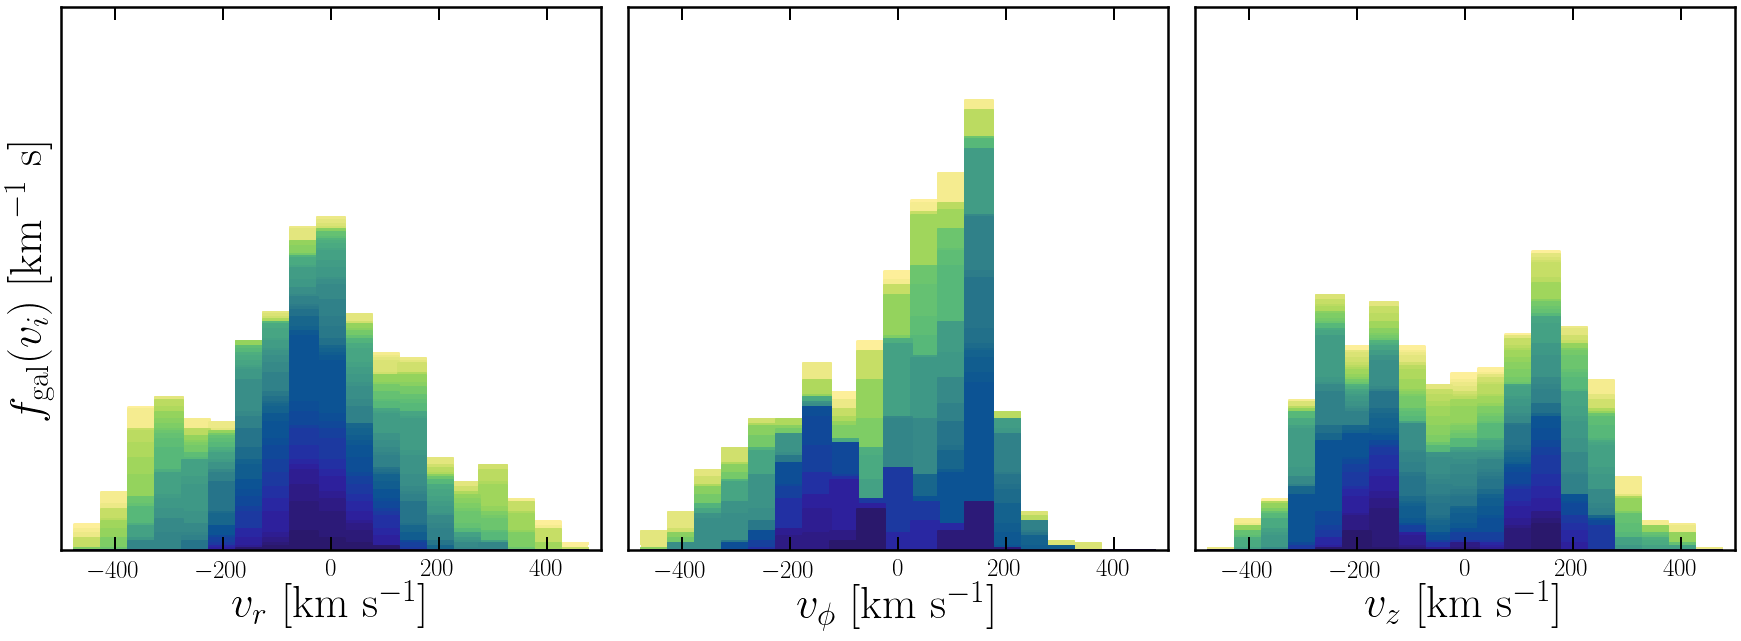

In [136]:
vlab1 = r"$v_r$ [km s$^{-1}$]"
vlab2 = r"$v_\phi$ [km s$^{-1}$]"
vlab3 = r"$v_z$ [km s$^{-1}$]"
ylab1 = r"$f_{\rm gal}(v_i)$ [km$^{-1}$ s]"
fig,ax1,ax2,ax3 = MyTriplePlot(vlab1,ylab1,vlab2,'',vlab3,'',wspace=0.05,size_y=10,size_x=30)
ymax = 10.0
vmax = 500.0
ax1.set_xlim([-vmax,vmax])
ax1.set_ylim(bottom=0.0,top=ymax)
ax2.set_xlim([-vmax,vmax])
ax2.set_ylim(bottom=0.0,top=ymax)
ax3.set_xlim([-vmax,vmax])
ax3.set_ylim(bottom=0.0,top=ymax)
ax1.set_yticks([])
ax2.set_yticks([])
ax3.set_yticks([])

ntot = shape(df_S)[0]
alph = 1.0
nbins = 20

names = df_S.group_id.unique()
ncands = size(names)
col_ex = (cmocean.cm.haline(linspace(0,1,ncands)))

s_mean = zeros(shape=ncands)
for i in range(0,ncands):
    dfc = df_S[df_S.group_id==names[i]]
    Cand_matched = df.loc[around(df.ra,8).isin(dfc.ra)]
    s_mean[i] = mean(Cand_matched.E)
names_sorted = names[argsort(s_mean)]

Examples = array([])
zorder = 1
for i in range(0,ncands):
    col = col_ex[i,:]
    Examples = append(Examples,names_sorted[i])
    dfc = df_S[df_S.group_id.isin(Examples)]    
    vr = dfc.GalRVel
    vphi = dfc.GalTVel
    vz = dfc.GalzVel
    h,vbins = histogram(vr,bins=nbins,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h = h/(1.0*ntot*nbins)
    ax1.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=zorder)
    ax1.step(vc,1e3*h,'-',color=col,lw=3,zorder=zorder)
    
    h,vbins = histogram(vphi,bins=nbins,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h = h/(1.0*ntot*nbins)
    ax2.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=zorder)
    ax2.step(vc,1e3*h,'-',color=col,lw=3,zorder=zorder)
    
    h,vbins = histogram(vz,bins=nbins,range=(-vmax,vmax))
    vc = (vbins[1:]+vbins[0:-1])/2
    h = h/(1.0*ntot*nbins)
    ax3.fill_between(vc,1e3*h,y2=0,color=col,lw=None,alpha=alph,step='pre',zorder=zorder)
    ax3.step(vc,1e3*h,'-',color=col,lw=3,zorder=zorder)
    zorder-=1


plt.show()

In [111]:
Jphi_mean = zeros(shape=ncands)
for i in range(0,ncands):
    dfc = df_S[df_S.group_id==names[i]]
    Jphi_mean[i] = mean(dfc.Jphi)
names_sorted_phi = names[argsort(Jphi_mean)]

array(['Rg1', 'Rg4', 'NCand29', 'S1', 'NCand15', 'Rg3', 'Rg2', 'Rg6',
       'NCand4', 'NCand11', 'Rg7', 'NCand19', 'NCand22', 'NCand20',
       'NCand27', 'NCand21', 'NCand7', 'Rg5', 'NCand18', 'NCand23',
       'NCand6', 'NCand1', 'Cand13', 'Cand18', 'NCand16', 'Cand10',
       'NCand28', 'NCand10', 'NCand9', 'Cand17', 'NCand0', 'Cand11',
       'NCand3', 'Cand12', 'NCand12', 'Cand16', 'C2', 'NCand2', 'S2',
       'NCand13', 'Cand9', 'Cand14', 'NCand26', 'Cand15', 'Cand8',
       'NCand25', 'NCand14', 'NCand5', 'NCand24', 'NCand17', 'NCand8'],
      dtype=object)